# Compile responses and compute DAT


## dependencies

In [1]:
import sys
sys.path.append('..') 
from scripts import dat
import pandas as pd
import numpy as np
import json
import pandas as pd
import os
import re
import glob
import warnings
warnings.filterwarnings('ignore')


## Compile adherence

## 1. Load data and model

In [2]:
# GloVe model from https://nlp.stanford.edu/projects/glove/
model_dat = dat.Model("../model/glove.840B.300d.txt", "../model/words.txt")

## Load human data

In [3]:
final_human_data = pd.read_csv('../human_data_dat/ai-creativity.csv')
DAT_100k = final_human_data['score']

## Load language models data

In [4]:
# Define a dictionary to store the results of model.dat(words)
results_dict = {'Temperature': [], 'Strategy': [], 'Score': [], 'Model': [], 'Control': [], 'Words': []}

# define counters
counter_gemini = 0
counter_gemini15 = 0
counter_geminiflash = 0
counter_geminiflash25 = 0
counter_geminiflashthinking = 0
counter_geminipro25 = 0
counter_gemma2 = 0
counter_gemma3 = 0
counter_gpt4_turbo = 0
counter_gpt4_0613 = 0
counter_gpt4_1106 = 0
counter_gpt4o = 0
counter_gpt4o_mini = 0
counter_gpt41 = 0
counter_gpt3 = 0
counter_gpt4 = 0
counter_o4_mini = 0
counter_claude = 0
counter_claude21 = 0
counter_claude3 = 0
counter_claude35_sonnet = 0
counter_stablelm = 0
counter_stablelmoasst = 0
counter_red = 0
counter_vicuna = 0
counter_llama3 = 0
counter_llama3_70b = 0
counter_llama31 = 0
counter_llama32 = 0
counter_llama4 = 0
counter_capy = 0
counter_hermes3 = 0
counter_deepseekr1 = 0
counter_qwen3 = 0

# Loop through each file in the data path
for file in sorted(glob.glob('../machine_data_dat/*.json')):
    # Open the file and load the JSON data
    with open(file, 'r') as f:
        data = json.load(f)
    file = os.path.basename(file)
    # Loop through each key in the JSON data
    for i in data.keys():
        # Split the words into a list
        words = data[i].split()

        # Find the indices of '1.' to '10.'
        indices = [m.start() for m in re.finditer(r'\b(?:[1-9]|10)\.', data[i])]  

        # Extract the words after '1.' to '10.' and store them in a new list
        new_words = []
        for idx in range(len(indices)):
            start_idx = indices[idx] + len(re.match(r'\b(?:[1-9]|10)\.', data[i][indices[idx]:]).group())
            if idx < len(indices) - 1:
                new_words.append(data[i][start_idx:indices[idx + 1]].strip())
            else:
                new_words.append(data[i][start_idx:].strip())

        # if no numbers are found, split by newline or bullet points
        if new_words == []:
            pattern = r'\b(?:[1-9]|10)\.\s*|\n\s*[-*]\s*'
            parts = re.split(pattern, data[i])
            # Filter out empty strings and strip whitespace
            new_words = [part.strip() for part in parts if part.strip()]
        
        if new_words != []:
            words = new_words

        # Split words that are comma-separated, newline-separated, or space-separated in a single string
        if len(words) == 1:
            words = [word for sublist in words for word in re.split(r'[,\n\s]+', sublist) if word]
        
        # Some lists contain an introductory statement to be removed
        if len(words) > 15:
            # Find the index of the colon
            try:
                colon_word = next((word for word in words if ':' in word), None)
                colon_index = words.index(colon_word)
                # Extract the words after the colon
                words = words[colon_index + 1:]
            except:
                print(file, words)
                continue
        # Remove "<nb>)" and "*" items from the list
        if len(words) > 15:
            words = [word for word in words if not re.match(r'\d+\)', word) and not re.match(r'\*', word)]
        if len(words) > 15:
            continue

        # lowercase the words
        words = [word.lower().strip() for word in words]
        
        # Define the strategy based on the file name
        if 'thes' in file:
            strategy = 'Thesaurus'
        elif 'oppo' in file:
            strategy = 'Opposition'
        elif 'ety' in file:
            strategy = 'Etymology'
        elif 'rand' in file:
            strategy = 'Random'
        elif 'none' in file:
            strategy = 'Original instructions'
        elif 'nothing' in file:
            strategy = 'Control'
        else:
            strategy = 'Original instructions'
        # Define the temperature based on the file name
        if 'temp1.5' in file:
            condition = 'High'
        elif 'temp0.5' in file:
            condition = 'Low'
        elif 'temp1.0' in file:
            condition = 'Mid'
        elif 'temp0.7' in file or "temp0.8" in file:
            condition = 'Mid'
        elif 'temp0.2' in file:
            condition = 'Low'
        elif 'temp0.9' in file:
            condition = 'High'
            if 'gemini' in file:
                condition = 'Mid'
        elif 'temp1.2' and 'claude' in file:
            condition = 'High'
        else:
            condition = 'Mid'
        
        # Define the model based on the file name
        if 'sample_gpt4_' in file:
            llm = 'GPT-4'
            if condition == 'Mid' and strategy == 'Original instructions':
                counter_gpt4 += 1
        elif 'sample_gpt4o_' in file:
            llm = 'GPT-4o'
            if condition == 'Mid' and strategy == 'Original instructions':
                counter_gpt4o += 1
        elif 'gpt4o-mini' in file:
            llm = 'GPT-4o-mini'
            if condition == 'Mid' and strategy == 'Original instructions':
                counter_gpt4o_mini += 1
        elif 'gpt4-0613' in file:
            llm = 'GPT-4-0613'
            if condition == 'Mid' and strategy == 'Original instructions':
                counter_gpt4_0613 += 1
        elif 'gpt4-1106' in file:
            llm = 'GPT-4-1106'
            if condition == 'Mid' and strategy == 'Original instructions':
                counter_gpt4_1106 += 1
        elif 'turbo' in file:
            llm = 'GPT-4-turbo'
            if condition == 'Mid' and strategy == 'Original instructions':
                counter_gpt4_turbo += 1
        elif 'sample_gpt4.1' in file:
            llm = 'GPT-4.1'
            if condition == 'Mid' and strategy == 'Original instructions':
                counter_gpt41 += 1
        elif 'o4-mini' in file:
            llm = 'o4-mini'
            if condition == 'Mid' and strategy == 'Original instructions':
                counter_o4_mini += 1
        elif 'gemini_' in file:
            llm = 'GeminiPro1'
            if condition == 'Mid' and strategy == 'Original instructions':
                counter_gemini += 1
        elif 'gemini1-5_' in file:
            llm = 'GeminiPro1.5'
            if condition == 'Mid' and strategy == 'Original instructions':
                counter_gemini15 += 1
        elif 'gemini1-5-flash' in file:
            llm = 'GeminiFlash'
            if condition == 'Mid' and strategy == 'Original instructions':
                counter_geminiflash += 1
        elif 'gemini-flash-2.5' in file:
            llm = 'GeminiFlash2.5'
            if condition == 'Mid' and strategy == 'Original instructions':
                counter_geminiflash25 += 1
        elif 'gemini-flash-thinking' in file:
            llm = 'GeminiFlash-thinking'
            if condition == 'Mid' and strategy == 'Original instructions':
                counter_geminiflashthinking += 1
        elif 'gemini-2.5-pro' in file:
            llm = 'GeminiPro2.5'
            if condition == 'Mid' and strategy == 'Original instructions':
                counter_geminipro25 += 1
        elif 'gemma2' in file:
            llm = 'Gemma2'
            if condition == 'Mid' and strategy == 'Original instructions':
                counter_gemma2 += 1
        elif 'gemma3' in file:
            llm = 'Gemma3'
            if condition == 'Mid' and strategy == 'Original instructions':
                counter_gemma3 += 1
        elif 'sample_claude_' in file:
            llm = 'Claude'
            if condition == 'Mid' and strategy == 'Original instructions':
                counter_claude += 1
        elif 'claude_2-1' in file:
            llm = 'Claude2.1'
            if condition == 'Mid' and strategy == 'Original instructions':
                counter_claude21 += 1
        elif 'claude_3' in file:
            llm = 'Claude3'
            if condition == 'Mid' and strategy == 'Original instructions':
                counter_claude3 += 1
        elif 'claude3-5-sonnet' in file:
            llm = 'Claude3.5-sonnet'
            if condition == 'Mid' and strategy == 'Original instructions':
                counter_claude35_sonnet += 1
        elif 'stablelm' in file:
            llm = 'StableLM'
            if condition == 'Mid' and strategy == 'Original instructions':
                counter_stablelm += 1
        elif 'redpajama7B' in file:
            llm='RedPajama'
            if condition == 'Mid' and strategy == 'Original instructions':
                counter_red += 1
        elif 'vicuna' in file:
            llm = 'Vicuna'
            if condition == 'Mid' and strategy == 'Original instructions':
                counter_vicuna += 1
        elif 'llama3_dat' in file:
            llm = 'Llama3'
            if condition == 'Mid' and strategy == 'Original instructions':
                counter_llama3 += 1
        elif 'llama3_70B' in file:
            llm = 'Llama3-70B'
            if condition == 'Mid' and strategy == 'Original instructions':
                counter_llama3_70b += 1
        elif 'llama3.1' in file:
            llm = 'Llama3.1'
            if condition == 'Mid' and strategy == 'Original instructions':
                counter_llama31 += 1
        elif 'llama3.2' in file:
            llm = 'Llama3.2' # 3B
            if condition == 'Mid' and strategy == 'Original instructions':
                counter_llama32 += 1
        elif 'llama4' in file:
            llm = 'Llama4'
            if condition == 'Mid' and strategy == 'Original instructions':
                counter_llama4 += 1
        elif 'capybarra' in file:
            llm = 'Capybara'
            if condition == 'Mid' and strategy == 'Original instructions':
                counter_capy += 1
        elif 'hermes3' in file:
            llm = 'Hermes3'
            if condition == 'Mid' and strategy == 'Original instructions':
                counter_hermes3 += 1
        elif 'deepseek-r1' in file:
            llm = 'DeepSeek-R1' # llama3.1 8b distillation
            if condition == 'Mid' and strategy == 'Original instructions':
                counter_deepseekr1 += 1
        elif 'qwen3' in file:
            llm = 'Qwen3-8B'
            if condition == 'Mid' and strategy == 'Original instructions':
                counter_qwen3 += 1 
        else:
            llm = 'GPT-3'
            if condition == 'Mid' and strategy == 'Original instructions':
                counter_gpt3 += 1
        
        # Loop through each word in the list
        score = model_dat.dat(words)
        # Append the results to the dictionary
        results_dict['Temperature'].append(condition)
        results_dict['Strategy'].append(strategy)
        results_dict['Score'].append(score)
        results_dict['Words'].append(words)
        results_dict['Model'].append(llm)
        # Add a columns with binary Control vs. experimental
        if strategy == 'Control':
            results_dict['Control'].append('Control')
        elif strategy == 'Original instructions':
            results_dict['Control'].append('Original instructions')
        else:
            results_dict['Control'].append('Strategy')

# Convert the results dictionary to a Pandas DataFrame
results_df = pd.DataFrame(results_dict)

Number of valid words 10
Number of valid words 10
Number of valid words 10
Number of valid words 10
Number of valid words 9
capybarra_dat_temp1.0_none02.json ['A', 'lake', 'a', 'sandwich', 'an', 'envelope', 'a', 'jet', 'a', 'design', 'a', 'rose', 'a', 'galaxy', 'a', 'joke', 'a', 'quartet', 'an', 'anchor.']
Number of valid words 4
Number of valid words 11
Number of valid words 10
Number of valid words 14
Number of valid words 9
Number of valid words 11
Number of valid words 9
Number of valid words 9
Number of valid words 10
Number of valid words 9
Number of valid words 10
capybarra_dat_temp1.0_none02.json ['A', 'tree', 'an', 'apple', 'a', 'star', 'a', 'pencil', 'a', 'keyboard', 'a', 'smile', 'a', 'book', 'a', 'piano', 'a', 'cloud', 'and', 'a', 'rainbow.']
Number of valid words 10
Number of valid words 10
Number of valid words 10
Number of valid words 7
Number of valid words 11
Number of valid words 8
Number of valid words 10
Number of valid words 10
Number of valid words 10
Number of va

## Compile adherence

In [5]:
counting = {
    "GPT-3": counter_gpt3,
    "GPT-4": counter_gpt4,
    "GPT-4o": counter_gpt4o,
    "GPT-4o-mini": counter_gpt4o_mini,
    "GPT-4-turbo": counter_gpt4_turbo,
    "GPT-4-0613": counter_gpt4_0613,
    "GPT-4-1106": counter_gpt4_1106,
    "GPT-4.1": counter_gpt41,
    "o4-mini": counter_o4_mini,
    "Claude": counter_claude,
    "Claude2.1": counter_claude21,
    "Claude3": counter_claude3,
    "Claude3.5-sonnet": counter_claude35_sonnet,
    "StableLM": counter_stablelm,
    "RedPajama": counter_red,
    "Vicuna": counter_vicuna,
    "Llama3": counter_llama3,
    "Llama3-70B": counter_llama3_70b,
    "Llama3.1": counter_llama31,
    "Llama3.2": counter_llama32,
    "Llama4": counter_llama4,
    "GeminiPro1": counter_gemini,
    "GeminiPro1.5": counter_gemini15,
    "GeminiFlash": counter_geminiflash,
    "GeminiFlash2.5": counter_geminiflash25,
    "GeminiFlash-thinking": counter_geminiflashthinking,
    "GeminiPro2.5": counter_geminipro25,
    "Gemma2": counter_gemma2,
    "Gemma3": counter_gemma3,
    "Capybara": counter_capy,
    "Hermes3": counter_hermes3,
    "DeepSeekR1": counter_deepseekr1,
    "Qwen3-8b": counter_qwen3
}
pd.DataFrame(counting.items(), columns=['Model', 'Count']).to_csv('total_responses_per_model.csv', index=False)

In [6]:
counting

{'GPT-3': 682,
 'GPT-4': 504,
 'GPT-4o': 503,
 'GPT-4o-mini': 492,
 'GPT-4-turbo': 500,
 'GPT-4-0613': 799,
 'GPT-4-1106': 496,
 'GPT-4.1': 506,
 'o4-mini': 37,
 'Claude': 989,
 'Claude2.1': 756,
 'Claude3': 578,
 'Claude3.5-sonnet': 557,
 'StableLM': 1488,
 'RedPajama': 1277,
 'Vicuna': 1000,
 'Llama3': 489,
 'Llama3-70B': 457,
 'Llama3.1': 573,
 'Llama3.2': 500,
 'Llama4': 500,
 'GeminiPro1': 800,
 'GeminiPro1.5': 600,
 'GeminiFlash': 699,
 'GeminiFlash2.5': 499,
 'GeminiFlash-thinking': 508,
 'GeminiPro2.5': 507,
 'Gemma2': 500,
 'Gemma3': 500,
 'Capybara': 452,
 'Hermes3': 500,
 'DeepSeekR1': 314,
 'Qwen3-8b': 301}

## Concatenate all human and machine data 

In [7]:
# concatenate with final sample
results_df = pd.concat([results_df, pd.DataFrame({'Temperature': np.tile(None, len(DAT_100k)),
                                                  'Strategy': np.tile('Original instructions', len(DAT_100k)),
                                                  'Score': np.array(DAT_100k),
                                                  'Model': np.tile('Human (100k)', len(DAT_100k)),
                                                  'Control': np.tile('Original instructions', len(DAT_100k))})])

In [8]:
results_df.Model.value_counts()

Model
Human (100k)            100000
GPT-3                     5556
GPT-4                     5298
StableLM                  4979
GeminiPro1                3660
Claude                    3212
Llama3.1                  2573
RedPajama                 2444
Vicuna                    2000
Claude2.1                 1556
Llama3.2                  1500
GPT-4-turbo               1255
Claude3                   1082
GPT-4-0613                 799
GeminiFlash                699
GeminiPro1.5               620
Claude3.5-sonnet           557
GeminiFlash-thinking       508
GeminiPro2.5               507
GPT-4.1                    506
GPT-4o                     503
Hermes3                    500
Llama4                     500
Gemma3                     500
Gemma2                     500
GeminiFlash2.5             499
GPT-4-1106                 496
GPT-4o-mini                492
Llama3                     489
Llama3-70B                 457
Capybara                   452
DeepSeek-R1                314
Qw

## Save all machine and human data

In [9]:
results_df.to_csv('concatenated_results_2025-06-18.csv', index=False)


In [10]:
results_df.head()

,Temperature,Strategy,Score,Model,Control,Words
0,Mid,Original instructions,88.121512,Capybara,Original instructions,"[asteroid, whisper, raspberry, cartography, cr..."
1,Mid,Original instructions,75.945661,Capybara,Original instructions,"[tree, smile, yarn, ocean, candle, truck, feat..."
2,Mid,Original instructions,79.783903,Capybara,Original instructions,"[ocean, pencil, cosmos, iron, coffee, book, sy..."
3,Mid,Original instructions,90.081697,Capybara,Original instructions,"[chameleon, oscilloscope, zeppelin, xylophone,..."
4,Mid,Original instructions,85.911355,Capybara,Original instructions,"[ocean, equation, rhinoceros, symphony, fragme..."


In [12]:
results_df.loc[results_df['Control']=='Original instructions'].groupby('Model')['Score'].mean().sort_values()[-10:]


Model
Hermes3         82.530420
GPT-4-1106      82.766461
Llama4          82.969440
Capybara        83.158111
GeminiPro1.5    83.587326
Llama3-70B      83.779675
GPT-4           84.194218
Llama3.2        84.614008
Llama3          84.628047
Llama3.1        85.405942
Name: Score, dtype: float64

In [28]:
# Count of NaN values per model and condition
nan_count_per_model_condition = results_df[results_df['Score'].isna()].groupby(['Model']).size().reset_index(name='NaN_Count')
print(nan_count_per_model_condition)
nan_indices = results_df[results_df['Score'].isna()].index
nan_words = results_df.loc[nan_indices, 'Words']
print(nan_words)
nan_words_per_model = results_df[results_df['Score'].isna()].groupby('Model')['Words'].apply(list).reset_index(name='NaN_Words')
print(nan_words_per_model)

                   Model  NaN_Count
0               Capybara         23
1                 Claude         69
2                Claude3          2
3            DeepSeek-R1         30
4                  GPT-3        105
5                  GPT-4        598
6            GPT-4-turbo         84
7   GeminiFlash-thinking          2
8         GeminiFlash2.5          2
9             GeminiPro1         38
10                Llama3         12
11              Llama3.1         49
12              Qwen3-8B          1
13             RedPajama        957
14              StableLM       1755
5               [*laughs*, that's, quite, the, challenge!]
5                                                      NaN
57       [true/false: you are a young adult with a love...
57                                                     NaN
73       [that's, an, interesting, challenge!, let, me,...
                               ...                        
42007                                                  NaN
42188    [b

In [80]:
reasoning_time = pd.read_csv("../qwen8b_dat_tempNone_none01_metrics.csv")

In [122]:
reasoning_time.iloc[243]['thinking']

'Okay, the user wants 10 nouns that are as different as possible. Let me start by thinking about different categories. First, maybe something natural like "mountain" and then contrast with man-made things like "skyscraper". Wait, but I need to make sure they are as different as possible. Let me think of different categories: maybe abstract concepts, physical objects, natural phenomena, etc.\n\nSo, "mountain" is a natural landform. Then "skyscraper" is a man-made structure. Next, maybe an abstract concept like "justice". Then a living thing, maybe "elephant". Wait, but "elephant" is an animal. Then maybe a concept like "time". Hmm, but "time" is abstract. What about something like "star" for celestial. Then a tool like "hammer". Wait, but "hammer" is a tool. Maybe "cloud" as a natural phenomenon. Then maybe "currency" as a concept. Wait, but I need to avoid specialized terms. Let me check each word.\n\n"Mountain" – okay. "Skyscraper" – okay. "Justice" – abstract concept. "Elephant" – an

In [123]:
results_df[results_df['Model'] == 'Qwen3-8B'].reset_index().iloc[243]

index                                                      15811
Temperature                                                  Mid
Strategy                                   Original instructions
Score                                                  80.124027
Model                                                   Qwen3-8B
Control                                    Original instructions
Words          [mountain, skyscraper, justice, elephant, star...
Name: 243, dtype: object

In [120]:
import numpy as np
from scipy import stats

qwen_scores = results_df[results_df['Model'] == 'Qwen3-8B']['Score'].dropna().values
qwen_time = reasoning_time['request_time'].drop(index=244).values  # Exclude the 244th index as it corresponds to a NaN score

correlation, p_value = stats.pearsonr(qwen_scores[2:], qwen_time[2:])
print(f"\nCorrelation coefficient (clean data): {correlation:.3f}")
print(f"P-value (clean data): {p_value:.3f}")


Correlation coefficient (clean data): 0.041
P-value (clean data): 0.480


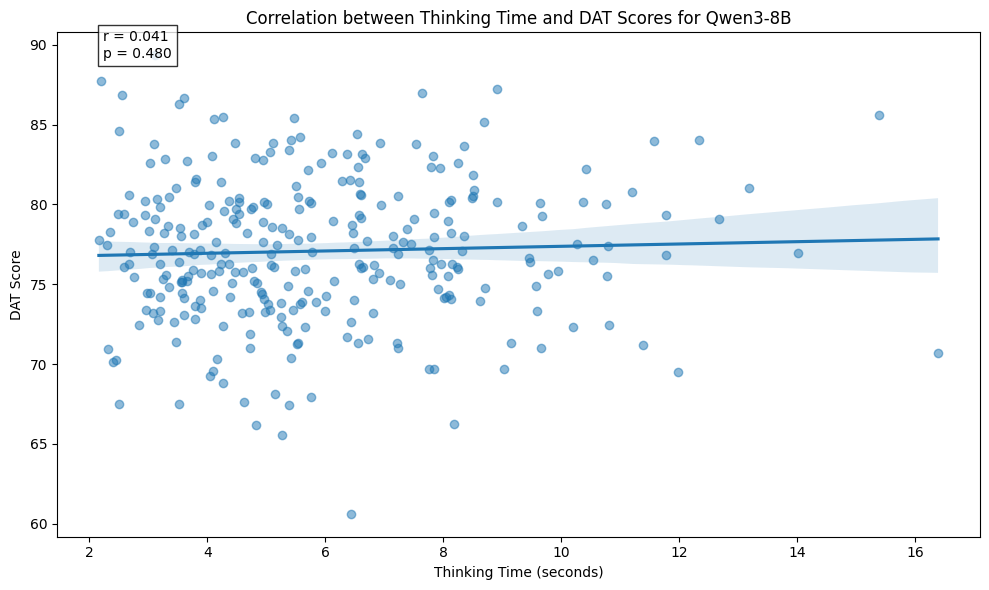

In [121]:
import seaborn as sns

import matplotlib.pyplot as plt

# Create scatterplot with regression line
plt.figure(figsize=(10, 6))
sns.regplot(x=qwen_time[2:], y=qwen_scores[2:], scatter_kws={'alpha':0.5})

# Customize plot
plt.title('Correlation between Thinking Time and DAT Scores for Qwen3-8B')
plt.xlabel('Thinking Time (seconds)')
plt.ylabel('DAT Score')

# Add correlation coefficient and p-value to plot
plt.text(0.05, 0.95, f'r = {correlation:.3f}\np = {p_value:.3f}', 
         transform=plt.gca().transAxes, 
         bbox=dict(facecolor='white', alpha=0.8))

plt.tight_layout()